<a href="https://colab.research.google.com/github/Nikhilam07/PRODIGY_ML_04/blob/main/hand_gesture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup & Download Dataset

In [1]:
# Install Kaggle & essentials
!pip install kaggle opencv-python tensorflow

# Upload your kaggle.json credentials here
from google.colab import files
files.upload()  # select your kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d gti-upm/leapgestrecog
!unzip -q leapgestrecog.zip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
 99% 2.12G/2.13G [00:15<00:00, 206MB/s]
100% 2.13G/2.13G [00:15<00:00, 149MB/s]


Preprocess & Load Data

In [2]:
import os, cv2, numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm

IMG_SIZE = 100  # resize to square

# Map folders to labels
lookup = {}
for idx, gesture in enumerate(sorted(os.listdir('leapGestRecog'))):
    if not gesture.startswith('.'):
        lookup[gesture] = idx
classes = lookup

# Load images
X, y = [], []
for gesture, label in lookup.items():
    gesture_path = os.path.join('leapGestRecog', gesture)
    for session in os.listdir(gesture_path):
        session_path = os.path.join(gesture_path, session)
        for img_name in os.listdir(session_path):
            img = cv2.imread(os.path.join(session_path, img_name), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(img)
            y.append(label)

X = np.array(X, dtype='float32') / 255.0
X = X[..., np.newaxis]  # add channel dim
y = to_categorical(y, num_classes=len(lookup))
print("Loaded", X.shape, "labels", y.shape)


Loaded (20000, 100, 100, 1) labels (20000, 10)


Train/Test Split



In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Build CNN Model

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(lookup), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,965,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,060,426 (15.49 MB)

 Trainable params: 4,060,426 (15.49 MB)

 Non-trainable params: 0 (0.00 B)

Train the Model


In [5]:
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=64,
    validation_data=(X_test, y_test)
)


Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.6954 - loss: 0.8818 - val_accuracy: 0.9893 - val_loss: 0.0313
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.9876 - loss: 0.0360 - val_accuracy: 0.9925 - val_loss: 0.0151
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9914 - loss: 0.0227 - val_accuracy: 0.9910 - val_loss: 0.0157
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9902 - loss: 0.0184 - val_accuracy: 0.9925 - val_loss: 0.0128
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9928 - loss: 0.0147 - val_accuracy: 0.9927 - val_loss: 0.0122
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9912 - loss: 0.0159 - val_accuracy: 0.9925 - val_loss: 0.0127
Epoch 7/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9917 - loss: 0.0175 - val_accuracy: 0.9908 - val_loss: 0.0139
Epoch 8/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9913 - loss: 0.0161 - val_a

Plot Training Results



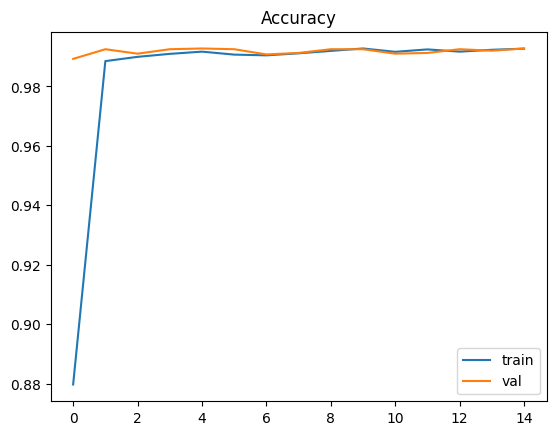

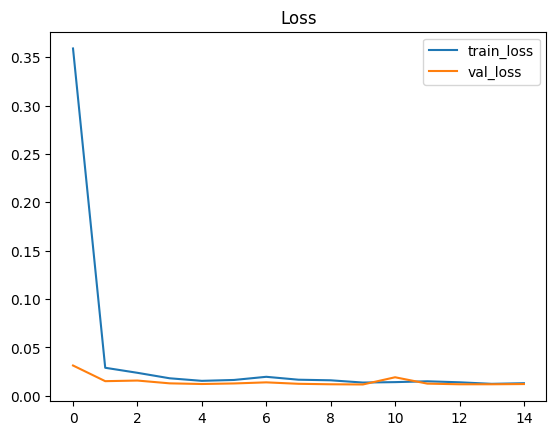

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()
plt.show()


Evaluate & View Predictions

Test accuracy: 99.27%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


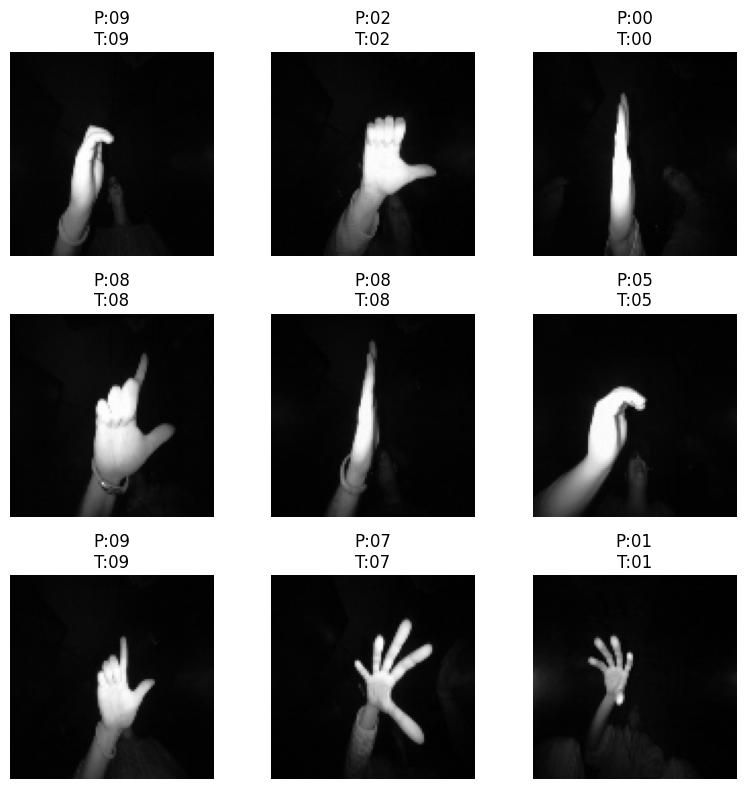

In [7]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {acc*100:.2f}%")

# Visualize some predictions
gesture_names = {v: k for k, v in lookup.items()}
fig, axes = plt.subplots(3,3, figsize=(8,8))
for i, ax in enumerate(axes.ravel()):
    idx = np.random.randint(len(X_test))
    img, true = X_test[idx], np.argmax(y_test[idx])
    pred = np.argmax(model.predict(img[np.newaxis,...]))
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"P:{gesture_names[pred]}\nT:{gesture_names[true]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


In [8]:
model.save("gesture_cnn_model.h5")

# Download to your system
from google.colab import files
files.download("gesture_cnn_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>